In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.pipeline import make_pipeline

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import classification_report, accuracy_score,confusion_matrix, ConfusionMatrixDisplay

from tensorflow import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout,BatchNormalization

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
!kaggle datasets download -d jessicali9530/lfw-dataset

 96% 108M/112M [00:01<00:00, 77.2MB/s] 
100% 112M/112M [00:01<00:00, 83.9MB/s]


In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('/content/lfw-dataset.zip', 'r')
zip_ref.extractall('/content/lfw-dataset')
zip_ref.close()

# PreProcessing

[ 0  1  2  3  4  5  6  7  8  9 10 11]


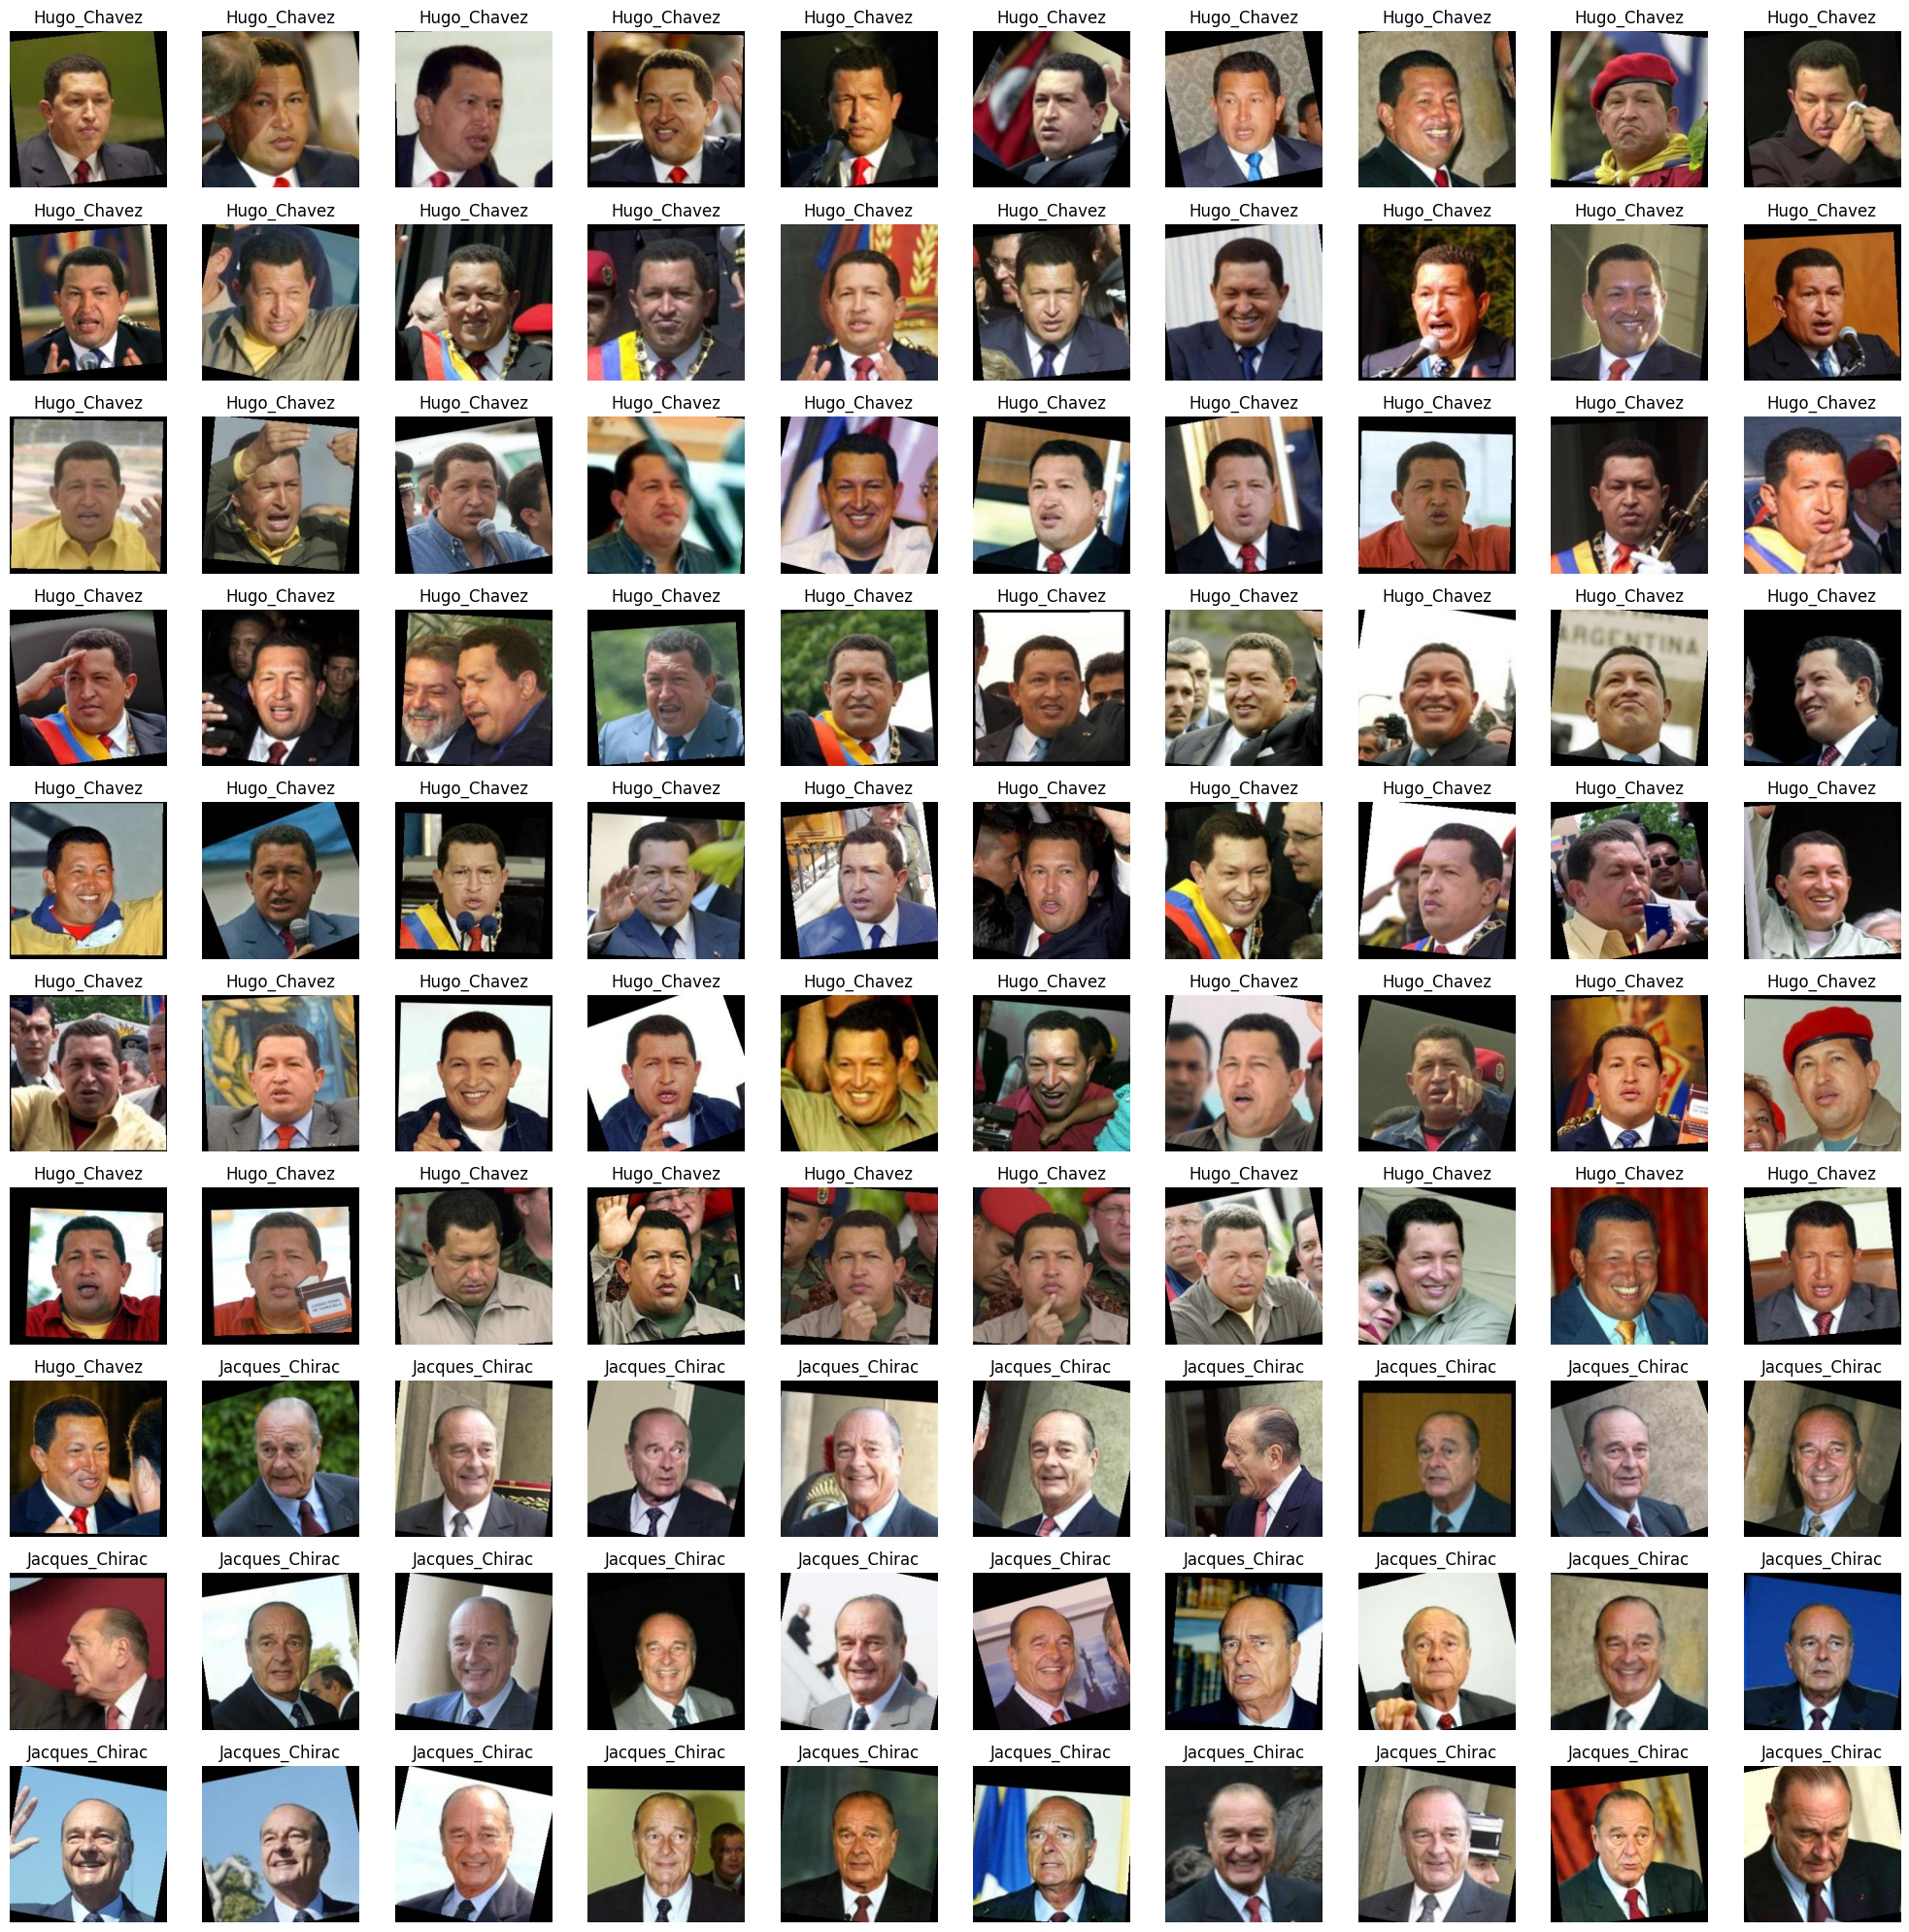

In [ ]:
# Step 1: Read the CSV file
people_df = pd.read_csv('/content/lfw-dataset/people.csv')

# Step 2: Extract file paths
lfw_folder_path = '/content/lfw-dataset/lfw-deepfunneled/lfw-deepfunneled'
image_paths = []
label_names=[]

for index, row in people_df.iterrows():
    person_name = str(row['name']).replace(' ', '_')  # Convert to string and replace spaces with underscores
    num_images = row['images']
    if num_images>=50:  # Check if num_images is not NaN
        num_images = int(num_images)  # Convert to integer
        for i in range(1, num_images + 1):
            image_paths.append(os.path.join(lfw_folder_path, person_name, f'{person_name}_{i:04d}.jpg'))  # Adjust image name format
            label_names.append(person_name)
image_paths=np.array(image_paths)
label_names=np.array(label_names)

#encoding labels from string to integer

label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(label_names)
print(np.unique(encoded_labels))

# Step 3: Display the first 100 images
fig, axes = plt.subplots(10, 10, figsize=(20, 20))
for i, ax in enumerate(axes.flat):
    image_path = image_paths[i]
    image = cv2.imread(image_path)
    image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    ax.set_title(label_names[i])
    ax.imshow(image)
    ax.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
# Display basic information about the dataset
print("Number of images:", len(image_paths))
print("Number of unique labels:", len(set(label_names)))

Number of images: 1560
Number of unique labels: 12


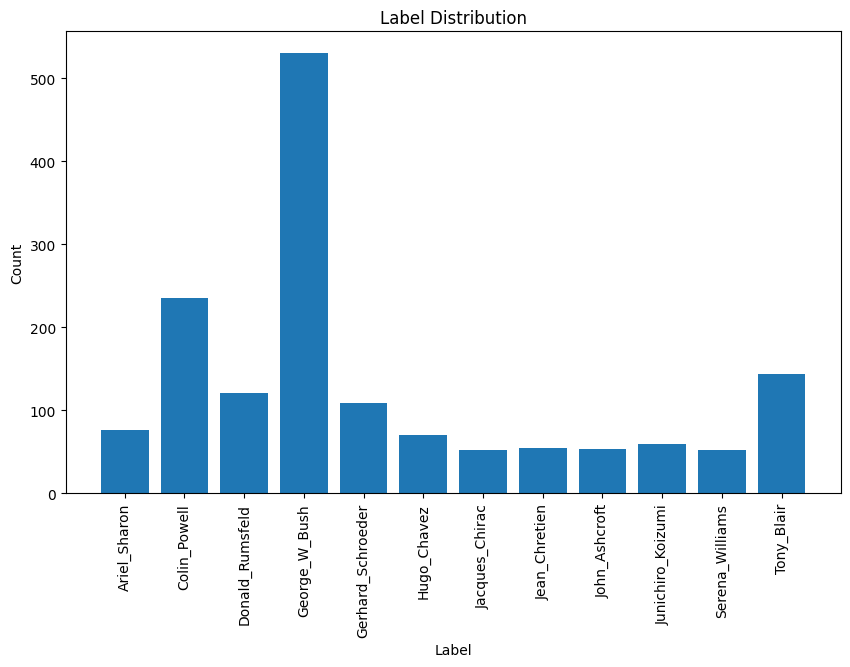

In [ ]:
# Visualizing label distribution
unique_labels, counts = np.unique(label_names, return_counts=True)

plt.figure(figsize=(10, 6))
plt.bar(unique_labels,counts)
plt.title('Label Distribution')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()

In [ ]:
# creating the image feature_set
images=[]
for path in image_paths:
    img=cv2.imread(path)
    images.append(img)
images=np.array(images)
images.shape

(1560, 250, 250, 3)

# LBP

In [ ]:
#This code can be used to extract Local Binary Pattern (LBP) Features.
#It takes Image Path and returns LBP feature.
import cv2
import numpy as np
from matplotlib import pyplot as plt

def get_pixel(img, center, x, y):
    new_value = 0
    try:
        if img[x][y] >= center:
            new_value = 1
    except:
        pass
    return new_value

def lbp_calculated_pixel(img, x, y):
    center = img[x][y]
    val_ar = []
    val_ar.append(get_pixel(img, center, x-1, y+1))     # top_right
    val_ar.append(get_pixel(img, center, x, y+1))       # right
    val_ar.append(get_pixel(img, center, x+1, y+1))     # bottom_right
    val_ar.append(get_pixel(img, center, x+1, y))       # bottom
    val_ar.append(get_pixel(img, center, x+1, y-1))     # bottom_left
    val_ar.append(get_pixel(img, center, x, y-1))       # left
    val_ar.append(get_pixel(img, center, x-1, y-1))     # top_left
    val_ar.append(get_pixel(img, center, x-1, y))       # top

    power_val = [1, 2, 4, 8, 16, 32, 64, 128]
    val = 0
    for i in range(len(val_ar)):
        val += val_ar[i] * power_val[i]
    return val


def calcLBP(img):
    height, width, channel = img.shape
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    img_lbp = np.zeros((height, width,3), np.uint8)
    for i in range(0, height):
        for j in range(0, width):
             img_lbp[i, j] = lbp_calculated_pixel(img_gray, i, j)
    hist_lbp = cv2.calcHist([img_lbp], [0], None, [256], [0, 256])
    return(hist_lbp)


def plot_lbp_histogram(hist_lbp):
    # hist_lbp.ravel() will convert the 2D histogram to a flat array
    plt.figure(figsize=(10, 4))
    plt.title("LBP Histogram")
    plt.xlabel("Bins")
    plt.ylabel("Number of Pixels")
    plt.plot(hist_lbp.ravel())
    plt.xlim([0, 256])
    plt.show()
# image_file = '/content/lfw-deepfunneled/lfw-deepfunneled/AJ_Cook/AJ_Cook_0001.jpg'
# img = cv2.imread(image_file)
# lbpFeature=calcLBP(img)
# print(lbpFeature)

In [ ]:
lbp_hist_features=[]
for img in tqdm(images):
    lbp_hist_features.append(calcLBP(img))
lbp_hist_features=np.array(lbp_hist_features)
lbp_hist_features=lbp_hist_features.reshape(len(lbp_hist_features),256)

100%|██████████| 1560/1560 [10:19<00:00,  2.52it/s]


In [ ]:
X_train, X_test, y_train, y_test = train_test_split( lbp_hist_features, encoded_labels, test_size=0.3, random_state=42)
scaler=StandardScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)

Accuracy for k=5 : 33.11965811965812%
Accuracy for k=10 : 35.47008547008547%
Accuracy for k=20 : 37.17948717948718%
Accuracy for k=40 : 37.17948717948718%
Accuracy for k=60 : 36.965811965811966%
Accuracy for k=80 : 36.965811965811966%


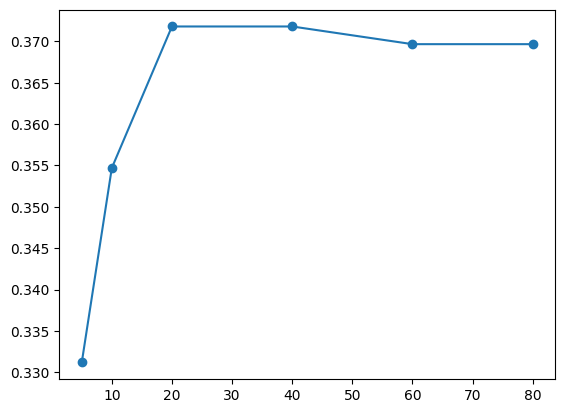

In [ ]:
accuracies=[]
k_values=[5,10,20,50,100]
for i in k_values:
    model_knn=KNeighborsClassifier(n_neighbors=i)
    model_knn.fit(X_train,y_train)
    y_pred=model_knn.predict(X_test)
    cur_acc=accuracy_score(y_test,y_pred)
    accuracies.append(cur_acc)
    print(f"Accuracy for k={i} : {cur_acc*100}%")
plt.plot(k_values, accuracies, marker='o')


In [ ]:
for n_comp in [2,5,10]:
    lda = LDA(n_components=n_comp)  # Reduce features to the most discriminative ones
    for k in [5,10,25,50,100]:
        knn=KNeighborsClassifier(n_neighbors=k)

        # Create a pipeline
        model = make_pipeline(lda, knn)

        # Fit and evaluate the model
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        print(f"Accuracy for {n_comp} components and {k} neighbors :",  "{:.2f}%".format(accuracy_score(y_test, y_pred)*100))
    print()


Accuracy for 2 components and 5 neighbors : 31.62%
Accuracy for 2 components and 10 neighbors : 35.90%
Accuracy for 2 components and 25 neighbors : 37.61%
Accuracy for 2 components and 50 neighbors : 36.54%
Accuracy for 2 components and 100 neighbors : 35.90%

Accuracy for 5 components and 5 neighbors : 35.26%
Accuracy for 5 components and 10 neighbors : 37.18%
Accuracy for 5 components and 25 neighbors : 38.68%
Accuracy for 5 components and 50 neighbors : 38.46%
Accuracy for 5 components and 100 neighbors : 39.10%

Accuracy for 10 components and 5 neighbors : 37.61%
Accuracy for 10 components and 10 neighbors : 38.25%
Accuracy for 10 components and 25 neighbors : 39.32%
Accuracy for 10 components and 50 neighbors : 39.32%
Accuracy for 10 components and 100 neighbors : 38.89%



From above implementation we can see best accuracy is obtained when 10 components are taken with k=50

In [ ]:
lda = LDA(n_components=10)
knn=KNeighborsClassifier(n_neighbors=50)

# Create a pipeline
model = make_pipeline(lda, knn)

# Fit and evaluate the model
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(f"Accuracy for {10} components and {40} neighbors :",  "{:.2f}%".format(accuracy_score(y_test, y_pred)*100))


Accuracy for 10 components and 40 neighbors : 39.32%


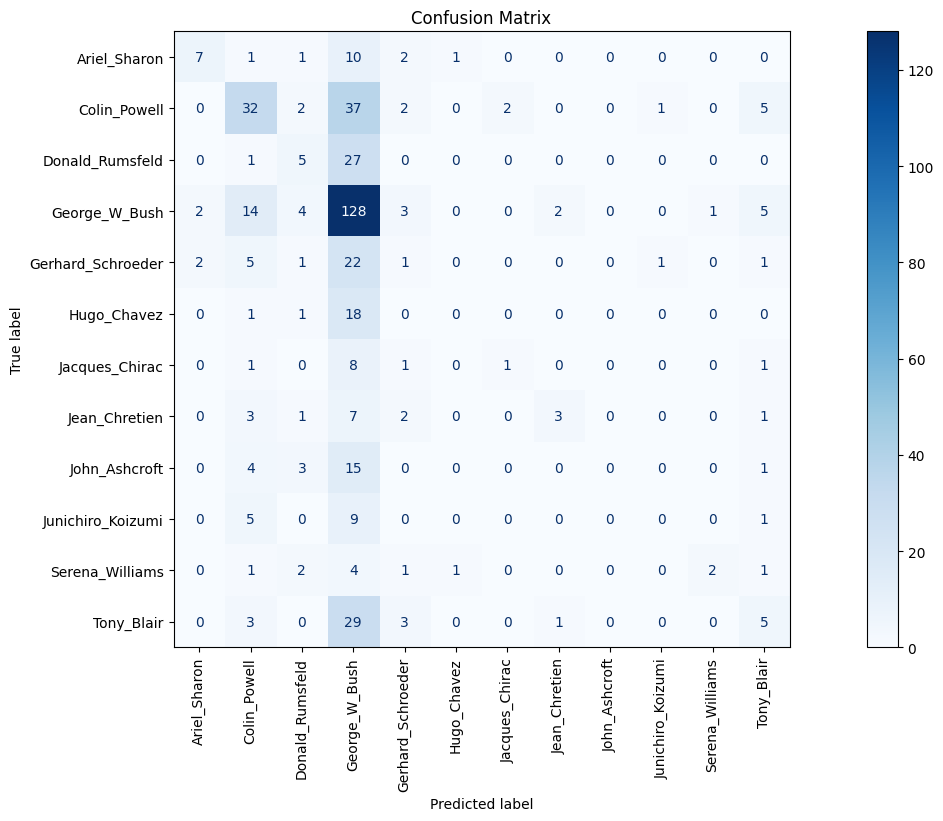

In [ ]:
# plotting confusion matrix
cm = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(20,8))  # Adjust the size as necessary
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

# Optionally add labels
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap=plt.cm.Blues, ax=ax)
ax.set_title('Confusion Matrix')
ax.set_xticklabels(disp.display_labels, rotation=90, ha="center")
# plt.tight_layout()
plt.show()

In [ ]:
for kernel in ['linear','poly','rbf']:
    svm_model = SVC(kernel=kernel)

    svm_model.fit(X_train, y_train)

    y_pred = svm_model.predict(X_test)

    print(f"Accuracy for {kernel} kernel:", "{:.2f}%".format(accuracy_score(y_test, y_pred)*100))

Accuracy for linear kernel: 35.26%
Accuracy for poly kernel: 35.04%
Accuracy for rbf kernel: 39.10%


from above results we can conclude that rbf kernel best suits for our data

Accuracy for n=20: 37.18%
Accuracy for n=50: 38.03%
Accuracy for n=100: 37.82%
Accuracy for n=150: 40.17%
Accuracy for n=200: 38.68%
Accuracy for n=500: 39.53%
Accuracy for n=750: 39.32%


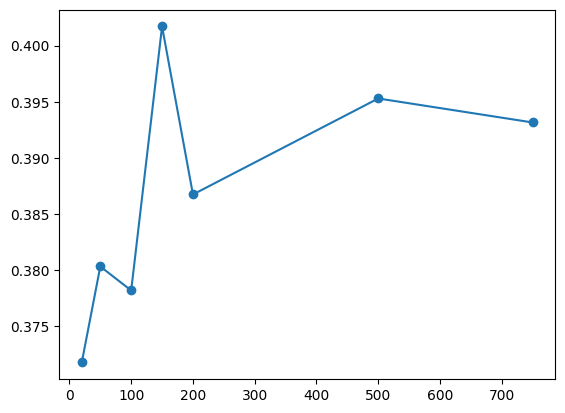

In [ ]:
n_values=[20,50,100,150,200,500,750]
accuracies=[]
for i in n_values:
    random_forest_model=RandomForestClassifier(n_estimators=i)

    random_forest_model.fit(X_train,y_train)
    y_pred=random_forest_model.predict(X_test)
    acc=accuracy_score(y_test, y_pred)
    accuracies.append(acc)
    print( f"Accuracy for n={i}:",  "{:.2f}%".format(accuracy_score(y_test, y_pred)*100))
    # print("\nClassification Report:\n", classification_report(y_test, y_pred))
plt.plot(n_values,accuracies,marker='o')

In [ ]:
model = Sequential([
    Dense(1024, activation='relu', input_shape=X_train[0].shape),
    Dropout(0.2),
    BatchNormalization(),
    Dense(512, activation='relu'),
    Dropout(0.2),
    BatchNormalization(),
    Dense(128, activation='relu'),
    Dropout(0.2),
    BatchNormalization(),
    Dense(len(np.unique(label_names)), activation='softmax')  # Assuming classification task
])

Early_Stopping = keras.callbacks.EarlyStopping(monitor = 'val_accuracy', patience = 15, restore_best_weights = True, verbose=1)

Reducing_LR = tf.keras.callbacks.ReduceLROnPlateau( monitor='val_loss',factor=0.6,patience=5,verbose=1)

callbacks = [Early_Stopping, Reducing_LR]

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
ann_history=model.fit(X_train,y_train, epochs=50, batch_size=32, validation_split=0.2,callbacks=callbacks)

# Evaluate the model
model.evaluate(X_test, y_test)

Epoch 1/50
28/28 [==============================] - 4s 15ms/step - loss: 2.9040 - accuracy: 0.1627 - val_loss: 2.3723 - val_accuracy: 0.2968 - lr: 0.0010
Epoch 2/50
28/28 [==============================] - 0s 8ms/step - loss: 2.0796 - accuracy: 0.3505 - val_loss: 2.4959 - val_accuracy: 0.2283 - lr: 0.0010
Epoch 3/50
28/28 [==============================] - 0s 8ms/step - loss: 1.6689 - accuracy: 0.4742 - val_loss: 2.2162 - val_accuracy: 0.3196 - lr: 0.0010
Epoch 4/50
28/28 [==============================] - 0s 7ms/step - loss: 1.3552 - accuracy: 0.5830 - val_loss: 2.0763 - val_accuracy: 0.3836 - lr: 0.0010
Epoch 5/50
28/28 [==============================] - 0s 7ms/step - loss: 1.2051 - accuracy: 0.6357 - val_loss: 2.1310 - val_accuracy: 0.3881 - lr: 0.0010
Epoch 6/50
28/28 [==============================] - 0s 7ms/step - loss: 0.9642 - accuracy: 0.7022 - val_loss: 2.2532 - val_accuracy: 0.3699 - lr: 0.0010
Epoch 7/50
28/28 [==============================] - 0s 8ms/step - loss: 0.8653 - 

[2.565793991088867, 0.4209401607513428]

In [ ]:
# function to plot accuracy and loss curves for neural network history
def plot_curves(history):

    loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]

    epochs = range(len(history.history["loss"]))

    plt.figure(figsize=(15,5))

    #plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label = "training_loss")
    plt.plot(epochs, val_loss, label = "val_loss")
    plt.title("Loss")
    plt.xlabel("epochs")
    plt.legend()

    #plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label = "training_accuracy")
    plt.plot(epochs, val_accuracy, label = "val_accuracy")
    plt.title("Accuracy")
    plt.xlabel("epochs")
    plt.legend()

15/15 [==============================] - 0s 4ms/step - loss: 2.5658 - accuracy: 0.4209
    Test Loss: 2.56579
Test Accuracy: 42.09%


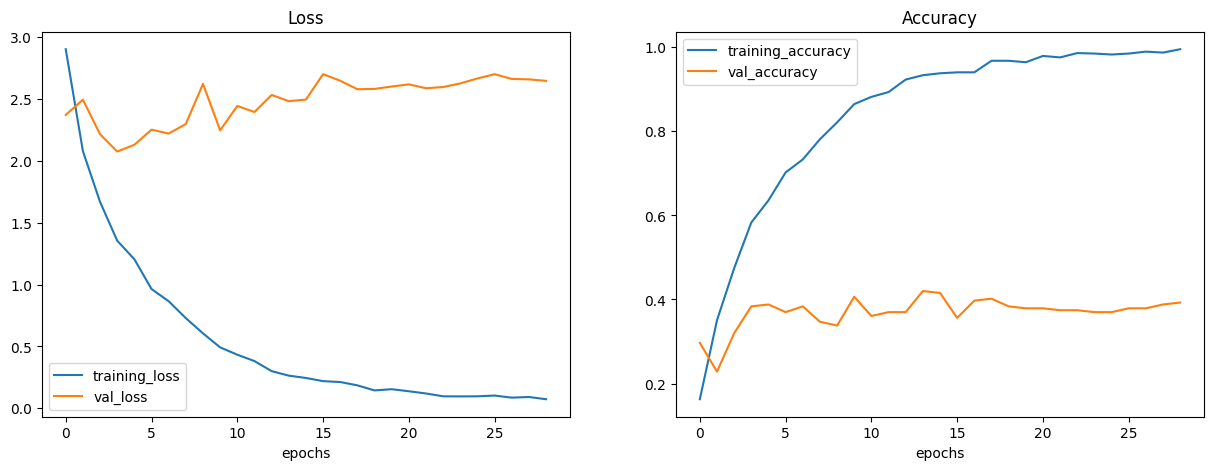

In [ ]:
ANN_Score = model.evaluate(X_test, y_test)

print("    Test Loss: {:.5f}".format(ANN_Score[0]))
print("Test Accuracy: {:.2f}%".format(ANN_Score[1] * 100))

plot_curves(ann_history)

# HoG

In [ ]:
#This code can be used to extract Histogram of Gradient (HoG) Features.
#It takes Image and returns HoG feature.
from skimage.io import imread
from skimage.transform import resize
from skimage.feature import hog
import matplotlib.pyplot as plt


def compute_hog(img):
  #resizing image
  resized_img = resize(img, (128*4, 64*4))
  #creating hog features
  fd, hog_image = hog(resized_img, orientations=9, pixels_per_cell=(8, 8),
                    cells_per_block=(2, 2), visualize=True, channel_axis=-1)
  return fd, hog_image


In [ ]:
hog_features=[]
hog_images=[]

for img in tqdm(images):
    Hog_feature, hog_image=compute_hog(img)
    hog_features.append(Hog_feature)
    hog_images.append(hog_images)
hog_features=np.array(hog_features)
hog_features.shape

100%|██████████| 1560/1560 [09:03<00:00,  2.87it/s]


(1560, 70308)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(hog_features, encoded_labels, test_size=0.2, random_state=42)
scaler=StandardScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)

In [ ]:
for n_comp in [1,5,10]:
    lda = LDA(n_components=n_comp)  # Reduce features to the most discriminative ones
    for k in [10,25,50,100]:
        knn=KNeighborsClassifier(n_neighbors=k)

        # Create a pipeline
        model = make_pipeline(lda, knn)

        # Fit and evaluate the model
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        print(f"Accuracy for {n_comp} components and {k} neighbors :",  "{:.2f}%".format(accuracy_score(y_test, y_pred)*100))
    print()

Accuracy for 1 components and 10 neighbors : 46.79%
Accuracy for 1 components and 25 neighbors : 49.36%
Accuracy for 1 components and 50 neighbors : 51.60%
Accuracy for 1 components and 100 neighbors : 51.60%

Accuracy for 5 components and 10 neighbors : 70.83%
Accuracy for 5 components and 25 neighbors : 71.47%
Accuracy for 5 components and 50 neighbors : 71.15%
Accuracy for 5 components and 100 neighbors : 66.99%

Accuracy for 10 components and 10 neighbors : 78.53%
Accuracy for 10 components and 25 neighbors : 76.28%
Accuracy for 10 components and 50 neighbors : 74.04%
Accuracy for 10 components and 100 neighbors : 65.06%



In [ ]:
# Initialize the SVM classifier
for kernel in ['linear','poly','rbf']:
    svm_classifier = SVC(kernel=kernel)  # Start with a linear kernel; adjust as needed
    svm_classifier.fit(X_train, y_train)

    # Evaluate the classifier
    y_pred = svm_classifier.predict(X_test)
    print(f"Accuracy for {kernel} kernel:",  "{:.2f}%".format(accuracy_score(y_test, y_pred)*100))

Accuracy for linear kernel: 87.82%
Accuracy for poly kernel: 30.77%
Accuracy for rbf kernel: 55.77%


In [ ]:
# Setup LDA followed by SVM
for n_comp in [1,2,5,10]:
    lda = LDA(n_components=n_comp)  # Reduce features to the most discriminative ones
    for kernel in ['linear','poly','rbf']:
        svm_classifier = SVC(kernel=kernel)

        # Create a pipeline
        model = make_pipeline(lda, svm_classifier)

        # Fit and evaluate the model
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        print(f"Accuracy for {n_comp} components and {kernel} kernel:",  "{:.2f}%".format(accuracy_score(y_test, y_pred)*100))
    print()

Accuracy for 1 components and linear kernel: 52.24%
Accuracy for 1 components and poly kernel: 45.19%
Accuracy for 1 components and rbf kernel: 51.28%

Accuracy for 2 components and linear kernel: 58.01%
Accuracy for 2 components and poly kernel: 52.88%
Accuracy for 2 components and rbf kernel: 57.69%

Accuracy for 5 components and linear kernel: 75.96%
Accuracy for 5 components and poly kernel: 59.62%
Accuracy for 5 components and rbf kernel: 72.76%

Accuracy for 10 components and linear kernel: 84.29%
Accuracy for 10 components and poly kernel: 62.82%
Accuracy for 10 components and rbf kernel: 82.69%



In [ ]:
HoG_ANN_model = Sequential([
    Dense(2048, activation='relu', input_shape=X_train[0].shape),
    Dropout(0.2),
    BatchNormalization(),
    Dense(1024, activation='relu'),
    Dropout(0.2),
    BatchNormalization(),
    Dense(512, activation='relu'),
    Dropout(0.2),
    BatchNormalization(),
    Dense(128, activation='relu'),
    Dropout(0.2),
    BatchNormalization(),
    Dense(len(np.unique(label_names)), activation='softmax')  # Assuming classification task
])

Early_Stopping = keras.callbacks.EarlyStopping(monitor = 'val_accuracy', patience = 15, restore_best_weights = True, verbose=1)

Reducing_LR = tf.keras.callbacks.ReduceLROnPlateau( monitor='val_loss',factor=0.5,patience=2,verbose=1)

callbacks = [Early_Stopping, Reducing_LR]

HoG_ANN_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
ann_history=HoG_ANN_model.fit(X_train,y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test),callbacks=callbacks)

# Evaluate the model
HoG_ANN_model.evaluate(X_test, y_test)

Epoch 1/50
39/39 [==============================] - 10s 90ms/step - loss: 2.1035 - accuracy: 0.3790 - val_loss: 3.2928 - val_accuracy: 0.5673 - lr: 0.0010
Epoch 2/50
39/39 [==============================] - 3s 68ms/step - loss: 0.7894 - accuracy: 0.7845 - val_loss: 1.2646 - val_accuracy: 0.7083 - lr: 0.0010
Epoch 3/50
39/39 [==============================] - 3s 67ms/step - loss: 0.3439 - accuracy: 0.9087 - val_loss: 0.7855 - val_accuracy: 0.7788 - lr: 0.0010
Epoch 4/50
39/39 [==============================] - 2s 62ms/step - loss: 0.1319 - accuracy: 0.9808 - val_loss: 0.6063 - val_accuracy: 0.8141 - lr: 0.0010
Epoch 5/50
39/39 [==============================] - 2s 64ms/step - loss: 0.0756 - accuracy: 0.9912 - val_loss: 0.5674 - val_accuracy: 0.8590 - lr: 0.0010
Epoch 6/50
39/39 [==============================] - 2s 46ms/step - loss: 0.0408 - accuracy: 0.9928 - val_loss: 0.4877 - val_accuracy: 0.8590 - lr: 0.0010
Epoch 7/50
39/39 [==============================] - 2s 44ms/step - loss: 0.

[0.4698615074157715, 0.8846153616905212]

10/10 [==============================] - 0s 10ms/step - loss: 0.4699 - accuracy: 0.8846
    Test Loss: 0.46986
Test Accuracy: 88.46%


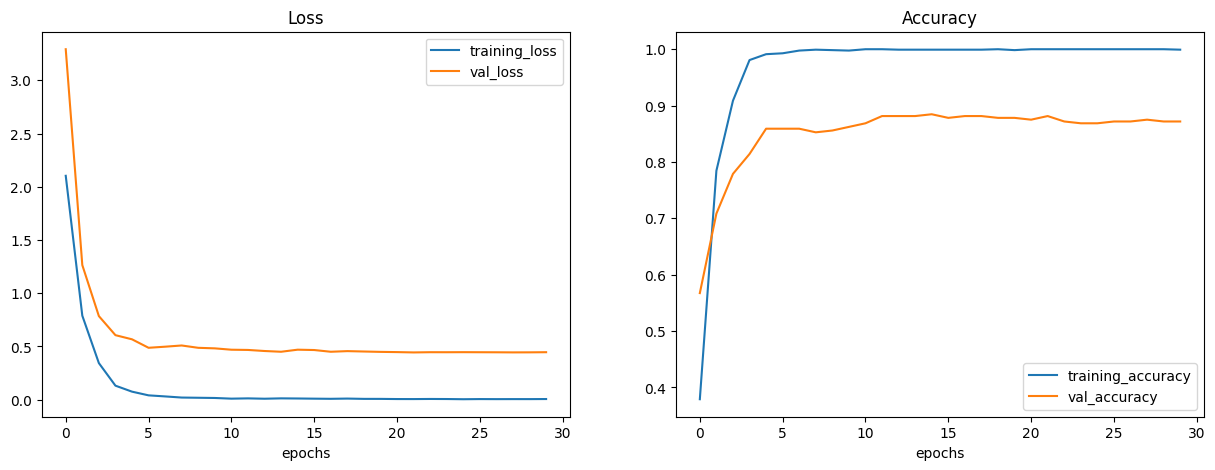

In [ ]:
ANN_Score = HoG_ANN_model.evaluate(X_test, y_test)

print("    Test Loss: {:.5f}".format(ANN_Score[0]))
print("Test Accuracy: {:.2f}%".format(ANN_Score[1] * 100))

plot_curves(ann_history)

#CNN

In [ ]:
#This code can be used to extract pretrained CNN (ResNet) Features.
#It takes Image Path and returns 2048-dimensional feature.
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image

# Load pre-trained ResNet-50 model
resnet = models.resnet50(pretrained=True)
# Remove the last fully connected layer
resnet = nn.Sequential(*list(resnet.children())[:-1])
# Set the model to evaluation mode
resnet.eval()

# Define a function to extract features from an image
def extract_features(image_path, model):
    # Load and preprocess the image
    image = Image.open(image_path).convert('RGB')
    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    image = preprocess(image)
    # Add batch dimension
    image = image.unsqueeze(0)
    # Extract features
    with torch.no_grad():
        features = model(image)
    # Remove the batch dimension
    features = features.squeeze(0)
    return features


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:02<00:00, 49.3MB/s]


In [ ]:
CNN_features=[]
for path in tqdm(image_paths):
    feat=extract_features(path,resnet)
    CNN_features.append(feat)
CNN_features=np.array(CNN_features)
CNN_features_res=CNN_features.reshape((len(CNN_features), 2048))

100%|██████████| 1560/1560 [04:46<00:00,  5.45it/s]


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(CNN_features_res, encoded_labels, test_size=0.2, random_state=42)
scaler=StandardScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)

In [ ]:
for n_comp in [1,2,5,10]:
    lda = LDA(n_components=n_comp)  # Reduce features to the most discriminative ones
    for k in [10,25,50,100,200]:
        knn=KNeighborsClassifier(n_neighbors=k)

        # Create a pipeline
        model = make_pipeline(lda, knn)

        # Fit and evaluate the model
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        print(f"Accuracy for {n_comp} components and {k} neighbors :",  "{:.2f}%".format(accuracy_score(y_test, y_pred)*100))
    print()


Accuracy for 1 components and 10 neighbors : 26.92%
Accuracy for 1 components and 25 neighbors : 27.56%
Accuracy for 1 components and 50 neighbors : 28.85%
Accuracy for 1 components and 100 neighbors : 28.21%
Accuracy for 1 components and 200 neighbors : 30.45%

Accuracy for 2 components and 10 neighbors : 37.50%
Accuracy for 2 components and 25 neighbors : 37.50%
Accuracy for 2 components and 50 neighbors : 38.46%
Accuracy for 2 components and 100 neighbors : 41.99%
Accuracy for 2 components and 200 neighbors : 39.10%

Accuracy for 5 components and 10 neighbors : 58.97%
Accuracy for 5 components and 25 neighbors : 59.94%
Accuracy for 5 components and 50 neighbors : 59.62%
Accuracy for 5 components and 100 neighbors : 60.26%
Accuracy for 5 components and 200 neighbors : 50.64%

Accuracy for 10 components and 10 neighbors : 72.12%
Accuracy for 10 components and 25 neighbors : 71.47%
Accuracy for 10 components and 50 neighbors : 72.12%
Accuracy for 10 components and 100 neighbors : 70.83

In [ ]:
for n in [10,20,50,100,200]:
    knn = KNeighborsClassifier(n_neighbors=n)
    knn.fit(X_train, y_train)  # Train the model

    # Prediction
    y_pred = knn.predict(X_test)

    # Evaluate
    print(f"Accuracy for k={n}:",  "{:.2f}%".format(accuracy_score(y_test, y_pred)*100))

Accuracy for k=10: 53.21%
Accuracy for k=20: 48.40%
Accuracy for k=50: 39.42%
Accuracy for k=100: 35.58%
Accuracy for k=200: 33.65%


In [ ]:
# Build a neural network model
model = Sequential([
    Dense(512, activation='relu', input_shape=(2048,)),
    Dropout(0.25),
    BatchNormalization(),
    Dense(256, activation='relu'),
    Dropout(0.25),
    BatchNormalization(),
    Dense(128, activation='relu'),
    Dropout(0.25),
    BatchNormalization(),
    Dense(64, activation='relu'),
    Dropout(0.25),
    BatchNormalization(),
    Dense(len(np.unique(label_names)), activation='softmax')  # Assuming classification task
])

Early_Stopping = keras.callbacks.EarlyStopping(monitor = 'val_accuracy', patience = 15, restore_best_weights = True, verbose=1)

Reducing_LR = tf.keras.callbacks.ReduceLROnPlateau( monitor='val_loss',factor=0.3,patience=4,min_lr=1e-6 ,verbose=1)

callbacks = [Early_Stopping, Reducing_LR]

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
ann_history=model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test),callbacks=callbacks)

# Evaluate the model
model.evaluate(X_test, y_test)

Epoch 1/50
39/39 [==============================] - 4s 14ms/step - loss: 2.6964 - accuracy: 0.1715 - val_loss: 2.3441 - val_accuracy: 0.2308 - lr: 0.0010
Epoch 2/50
39/39 [==============================] - 0s 7ms/step - loss: 2.0121 - accuracy: 0.3790 - val_loss: 1.6404 - val_accuracy: 0.5032 - lr: 0.0010
Epoch 3/50
39/39 [==============================] - 0s 7ms/step - loss: 1.5253 - accuracy: 0.5321 - val_loss: 1.4059 - val_accuracy: 0.5865 - lr: 0.0010
Epoch 4/50
39/39 [==============================] - 0s 8ms/step - loss: 1.3177 - accuracy: 0.6066 - val_loss: 1.2819 - val_accuracy: 0.5929 - lr: 0.0010
Epoch 5/50
39/39 [==============================] - 0s 7ms/step - loss: 1.1618 - accuracy: 0.6274 - val_loss: 1.2665 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 6/50
39/39 [==============================] - 0s 7ms/step - loss: 0.9686 - accuracy: 0.7075 - val_loss: 1.1415 - val_accuracy: 0.6763 - lr: 0.0010
Epoch 7/50
39/39 [==============================] - 0s 6ms/step - loss: 0.8535 - 

[0.8594192862510681, 0.7916666865348816]

10/10 [==============================] - 0s 3ms/step - loss: 0.8594 - accuracy: 0.7917
    Test Loss: 0.85942
Test Accuracy: 79.17%


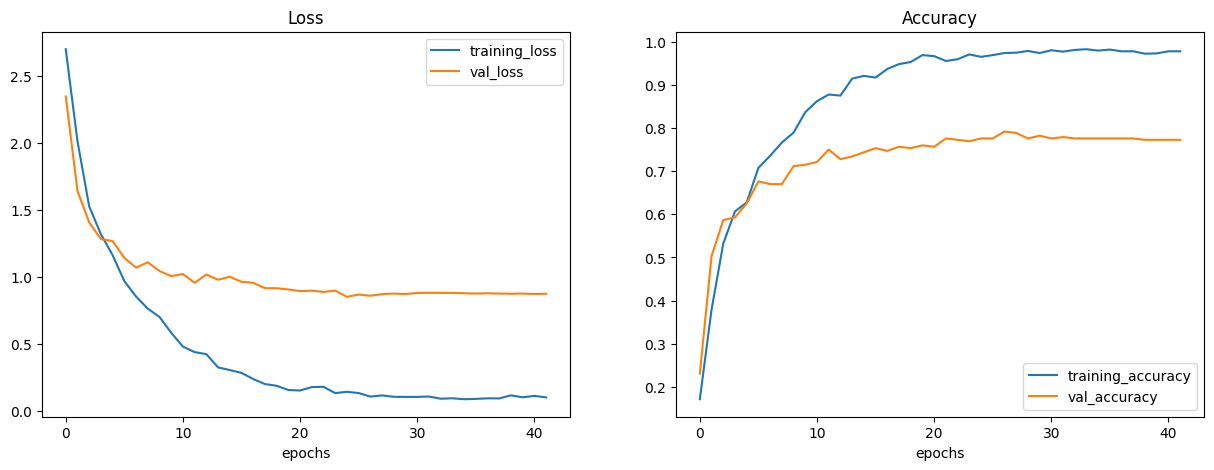

In [ ]:
ANN_Score = model.evaluate(X_test, y_test)

print("    Test Loss: {:.5f}".format(ANN_Score[0]))
print("Test Accuracy: {:.2f}%".format(ANN_Score[1] * 100))

def plot_curves(history):

    loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]

    epochs = range(len(history.history["loss"]))

    plt.figure(figsize=(15,5))

    #plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label = "training_loss")
    plt.plot(epochs, val_loss, label = "val_loss")
    plt.title("Loss")
    plt.xlabel("epochs")
    plt.legend()

    #plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label = "training_accuracy")
    plt.plot(epochs, val_accuracy, label = "val_accuracy")
    plt.title("Accuracy")
    plt.xlabel("epochs")
    plt.legend()
plot_curves(ann_history)

In [ ]:
# Setup LDA followed by SVM
for n_comp in [1,2,5,10]:
    lda = LDA(n_components=n_comp)  # Reduce features to the most discriminative ones
    for kernel in ['linear','poly','rbf']:
        svm_classifier = SVC(kernel=kernel)

        # Create a pipeline
        model = make_pipeline(lda, svm_classifier)

        # Fit and evaluate the model
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        print(f"Accuracy for {n_comp} components and {kernel} kernel :",  "{:.2f}%".format(accuracy_score(y_test, y_pred)*100))
    print()

Accuracy for 1 components and linear kernel : 30.45%
Accuracy for 1 components and poly kernel : 32.37%
Accuracy for 1 components and rbf kernel : 29.81%

Accuracy for 2 components and linear kernel : 37.50%
Accuracy for 2 components and poly kernel : 41.35%
Accuracy for 2 components and rbf kernel : 38.14%

Accuracy for 5 components and linear kernel : 57.05%
Accuracy for 5 components and poly kernel : 58.97%
Accuracy for 5 components and rbf kernel : 58.65%

Accuracy for 10 components and linear kernel : 69.55%
Accuracy for 10 components and poly kernel : 63.14%
Accuracy for 10 components and rbf kernel : 72.44%



# Conclusion
After testing and implementing different models on LBP, HoG and CNN features, We can conclude that best accuracy is obtained for ANN model on HoG features.

49/49 [==============================] - 0s 9ms/step
Accuracy by applying ANN on HoG features : 97.69%


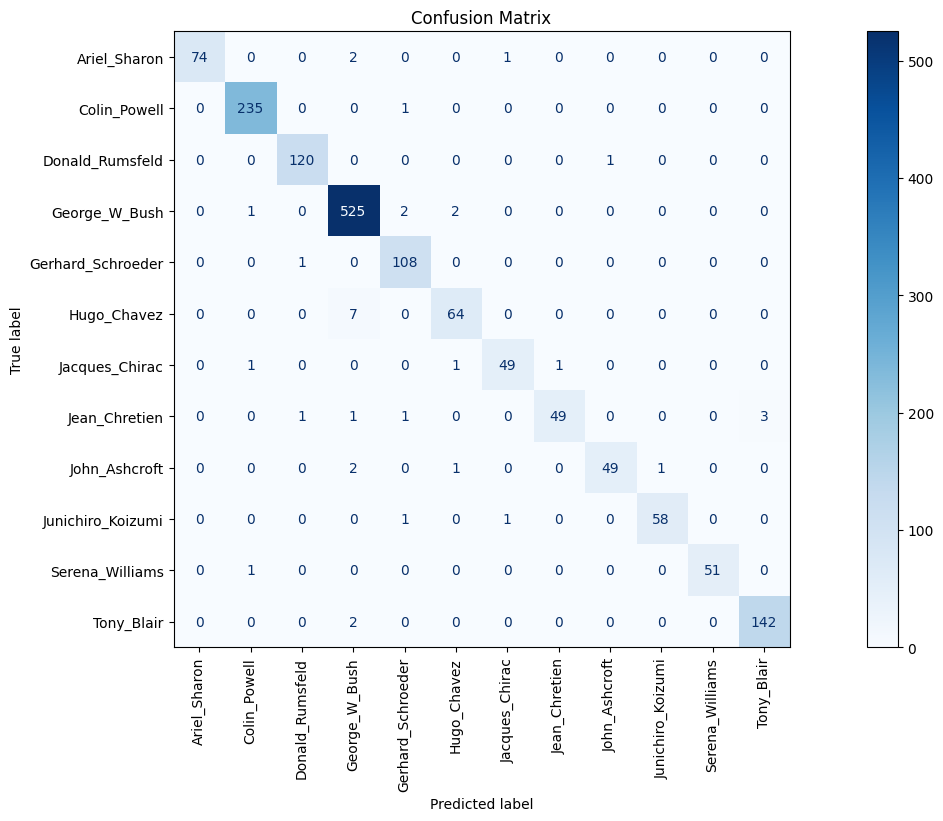

In [ ]:
scaler=StandardScaler()
Hog_scaled=scaler.fit_transform(hog_features)
y_pred=HoG_ANN_model.predict(Hog_scaled)
y_pred=np.argmax(y_pred,axis=1)
# plotting confusion matrix
print(f"Accuracy by applying ANN on HoG features :",  "{:.2f}%".format(accuracy_score(encoded_labels, y_pred)*100))
cm = confusion_matrix(encoded_labels, y_pred)
fig, ax = plt.subplots(figsize=(20,8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

# Optionally add labels
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap=plt.cm.Blues, ax=ax)
ax.set_title('Confusion Matrix')
ax.set_xticklabels(disp.display_labels, rotation=90, ha="center")
# plt.tight_layout()
plt.show()

1/1 [==============================] - 0s 32ms/step
accuracy :  1.0


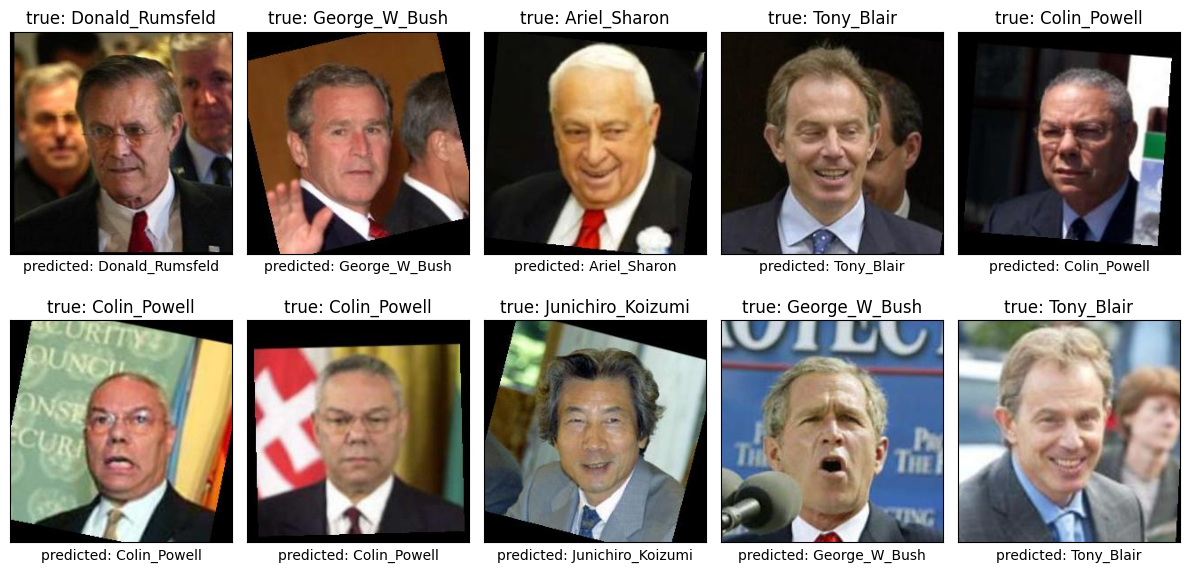

In [ ]:
# visualizing predictions on our best model for 10 random images from dataset

#taking 10 random samples
ind=np.random.permutation(len(images))[:10]

# Best model is HoG_ANN_model
y_pred=HoG_ANN_model.predict(Hog_scaled[ind])
y_pred=np.argmax(y_pred,axis=1)
y_pred=label_encoder.inverse_transform(y_pred)
y_true=label_encoder.inverse_transform(encoded_labels[ind])

import random
print("accuracy : ",accuracy_score(y_true,y_pred))
plt.figure(figsize=(12, 6))
for j in range(0,10):
    plt.subplot(2, 5, j + 1)
    plt.xticks(())
    plt.yticks(())
    # i=random.randint(0,len(images)-1)
    plt.title(f"true: {y_true[j]}")
    # print()
    plt.imshow(cv2.cvtColor(images[ind[j]],cv2.COLOR_BGR2RGB))
    plt.xlabel(f"predicted: {y_pred[j]}")
plt.tight_layout()
plt.show()